# 1. Set up youtube api call

In [53]:
from googleapiclient.discovery import build
import pandas as pd
import mercury as mr
import numpy as np

In [7]:
#api_key is an environment variable
api_service_name = "youtube"
api_version = "v3"
youtube = build(
    api_service_name, api_version, developerKey=api_key)

# 2. Request 50 English channels about data science

In [8]:
def get_channel(youtube, max_results):
    
    request = youtube.search().list(
        part="snippet",
        maxResults=max_results,
        q="data science",
        relevanceLanguage="en",
        type="channel"
    )
    response = request.execute()
    
# channel ids are included in the "snippet", which itself is included in "items"
# iterate all "items" to find and store the 50 channel id
    
    channel_ids = []
    for item in response['items']:
        channel = item['snippet']['channelId']
        channel_ids.append(channel)
        
    return channel_ids

channel_ids = get_channel(youtube, 50)

# 3. Get stats and playlist of these 50 channels

In [9]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    
    response = request.execute()
    
    for item in response['items']:
        
        data = {'channelName': item['snippet']['title'],
               'subscribers': item['statistics']['subscriberCount'],
               'views': item['statistics']['viewCount'],
               'totalVideos': item['statistics']['videoCount'],
               'playListID': item['contentDetails']['relatedPlaylists']['uploads']}
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [10]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [11]:
channel_stats

,channelName,subscribers,views,totalVideos,playListID
0,Data Science Analytics,11100,1188884,68,UUB2p-jaoolkv0h22m4I9l9Q
1,MYANMAR DATA SCIENCE,9410,294506,201,UU0g9jkx4MwsojJfBt1MnWew
2,The Data Scientist Show - Daliana Liu,8890,133417,112,UUa0RTSXWyZdh7IciV9r-3ow
3,DATA SCIENCE LOVERS,19100,845053,104,UUwk47V1XafOrw83d_vwwGhg
4,Data Science Simplified,2710,54296,84,UUNMawpMow-lW5d2svGhOEbw
5,DataScience RoadMap,10700,302236,184,UUAEgip72UcvYwjcqzcJ1I2g
6,NYU Data Science,3670,202331,33,UUjxoi1kA0twXJsVnIq2vMHA
7,Everyday Data Science,6530,357465,287,UUoltS35pWaswSV634-n-H3A
8,AUC Data Science Initiative,296,6056,54,UUxLeafaLWeGxwJSWJC247jw
9,Dr. Data Science,3630,150837,40,UUq8JE4cOzY_CHy7f1PwbwwQ


# 4. Get 50 videos of each channel

In [13]:
def get_video_ids(youtube, playlists):
    
    video_ids = []
    
    for playlist_id in playlists:

        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
    return video_ids


In [14]:
video_ids = get_video_ids(youtube, channel_stats['playListID'])

# 5. Get title, number of views and other information of each video

In [15]:
def get_video_info(youtube, video_ids):    

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [17]:
video_info = = get_video_info(youtube, video_ids)
video_info

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration
0,6psm_Y5QREU,Data Science Analytics,StatsLearning Chapter 10 - part 3,,None,2018-06-15T16:51:00Z,9974,61,None,3,PT17M18S
1,7r3jfKKXhjY,Data Science Analytics,StatsLearning Chapter 10 - part 4,,None,2018-06-15T16:50:51Z,7367,56,None,2,PT14M46S
2,zMfomUERNww,Data Science Analytics,StatsLearning Chapter 10 - part 2,,None,2018-06-15T16:50:36Z,9625,53,None,0,PT17M40S
3,59TkGcuh5FA,Data Science Analytics,StatsLearning Chapter 10 - part 5,,None,2018-06-15T16:50:23Z,5440,40,None,2,PT9M25S
4,WIMgMBYqhKE,Data Science Analytics,StatsLearning Chapter 10 - part 1,,None,2018-06-15T16:49:44Z,14796,96,None,2,PT12M37S
...,...,...,...,...,...,...,...,...,...,...,...
2204,jpj71hltkVQ,Data Science for Everyone,Financial Data with Python,Financial Data\nThis section works with a loca...,"[data science, data science for everyone, data...",2021-12-22T15:00:43Z,717,26,None,10,PT20M40S
2205,oWkxWC9bc5Q,Data Science for Everyone,Candlestick Plot with JNJ & COVID Timeline,We more forward with candlestick charts by loo...,"[data science, data science for everyone, data...",2021-12-10T15:00:25Z,202,8,None,2,PT18M1S
2206,uidT_mdBzn4,Data Science for Everyone,Introduction to Quick Candlestick Plots with P...,The candlestick chart is a style of financial ...,"[data science, data science for everyone, data...",2021-12-08T15:00:27Z,471,16,None,0,PT7M44S
2207,lLYi-L5ptAk,Data Science for Everyone,Interactive Financial Plots with Plotly Express,In this video we will show you how to create q...,"[data science, data science for everyone, data...",2021-12-03T18:00:14Z,699,15,None,2,PT7M22S


# 5. Data Cleaning

In [18]:
# cehck null_value
video_info.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount       True
duration          False
dtype: bool

In [19]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount']
video_info[numeric_cols] = video_info[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [20]:
# convert pulishedAt to date format
video_info['publishedAt'] = video_info['publishedAt'].apply(pd.to_datetime)

In [21]:
# convert duration to seconds
import isodate
video_info['durationSecs'] = video_info['duration'].apply(lambda x: isodate.parse_duration(x))
video_info['durationSecs'] = video_info['durationSecs'].astype('timedelta64[s]')

# 6. EDA

### 6.1 Check distribution of viewCount

In [22]:
video_info['viewCount'] = video_info['viewCount'].astype(int)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

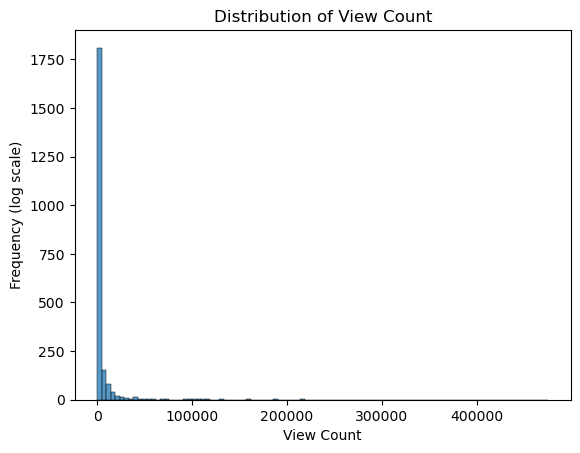

In [25]:
ax = sns.histplot(data=video_info, x='viewCount', bins=100)

# Set the labels and title
plt.xlabel('View Count')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of View Count')

# Show the plot
plt.show()

In [319]:
#The distribution of viewCount is too skewed. Therefore use logarithm transformation for better visualization

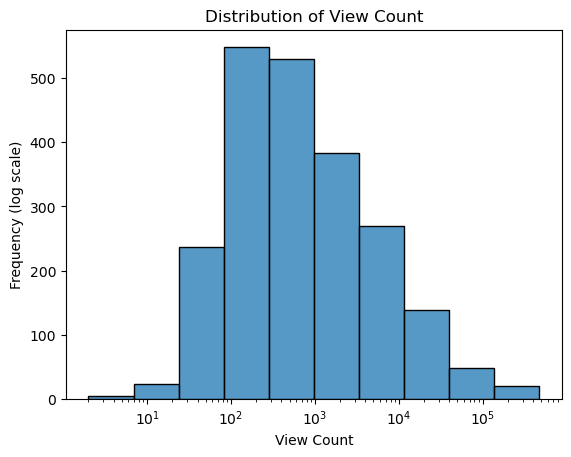

In [26]:
ax = sns.histplot(data=video_info[video_info['viewCount'] >0], x='viewCount', bins=10, log_scale=True)

# Set the labels and title
plt.xlabel('View Count')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of View Count')

# Show the plot
plt.show()

Finding from EDA: majority videos have views less than 1000, but there are a small number of videos that have large number of views

### 6.2 Explore why some videos have more viewCount

#### Possible reason 1: some channels have more subscribers, and therefore have more visibility

In [30]:
video_info.groupby('channelTitle')['viewCount'].agg(['min', 'max', 'mean', 'std'])

,min,max,mean,std
channelTitle,,,,
365 Data Science,855,148353,19464.520000,27777.719243
AUC Data Science Initiative,14,802,111.520000,160.755644
Anastasia K,1041,324779,31895.175000,59987.381397
Becoming a Data Scientist,138,68150,6882.960000,13707.070809
Better Data Science,90,20381,3224.120000,4458.428114
DATA SCIENCE LOVERS,88,93655,3606.020000,13558.597960
Data School,1713,40473,8226.220000,7602.912560
Data Science Academy,149,213848,5542.290323,27409.507575
Data Science Analytics,2842,23384,9837.040000,4790.711485


Indeed different channels have very differenty average viewCount. But within each channel, the viewCount could be very dfferent as well.

#### Possible reason 2: for each channel, the viewCount gradually grow

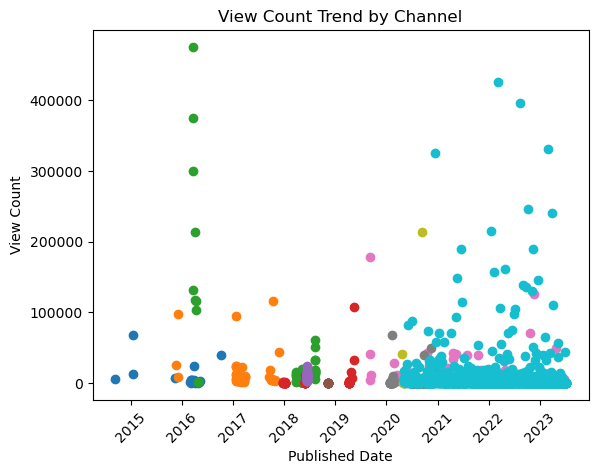

In [33]:
from matplotlib.cm import get_cmap

# Sort the DataFrame by the 'publishedAt' column
df = video_info.sort_values('publishedAt')

# Create a colormap for the channels
cmap = get_cmap('tab10')

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over each unique channel

for i, channel in enumerate(channels):
    # Filter the DataFrame for the current channel
    channel_df = df[df['channelTitle'] == channel]
    
    # Extract the x (publishedAt) and y (viewCount) values
    x = channel_df['publishedAt']
    y = channel_df['viewCount']
    
    # Plot the scatter plot for the current channel with a unique color
    ax.scatter(x, y, color=cmap(i), label=channel)

# Set labels and title
ax.set_xlabel('Published Date')
ax.set_ylabel('View Count')
ax.set_title('View Count Trend by Channel')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

We can clearly see that published date is not relevant with views from the above scatterplot. For example, for the channel that is represented by the light blue dots, from 2020 to 2023, eahc year this channel has a few videos that have large number of views, and the rest videos it published within that year has much fewer views

#### Possible reason 3: The topic matters

We want to compare the title of popular videos and unpopular videos. To adjust for the fact that some channel naturally has more visibility, we define popular videos are ones that have a viewCount that is above both the median viewCount in the entire dataset, as well as the median viewCount of all videos in its channel. Conversely, unpopular videos are ones that have a viewCount that is below the median viewCount in the entire dataset, as well as the median viewCount of its own channel

In [56]:
#calculate the median viewCount of each channel, and the median viewCount in general
median_viewCount = video_info['viewCount'].median()
median_viewCount_byChannel = video_info.groupby('channelTitle').median()['viewCount']

#create a new column in the dataset to store the median viewCount of each channel
video_info['channelMedianViewCount'] = video_info['channelTitle'].map(median_viewCount_byChannel)

#select top-performing and bottom-performing videos
top_videos = video_info[np.logical_and(video_info['viewCount'] > median_viewCount, video_info['viewCount'] > video_info['channelMedianViewCount'])]
bottom_videos = video_info[np.logical_and(video_info['viewCount'] < median_viewCount, video_info['viewCount'] < video_info['channelMedianViewCount'])]

#### Use word cloud to visualize the titles of top-performing and bottom-performing videos to compare topic difference

In [61]:
from wordcloud import WordCloud

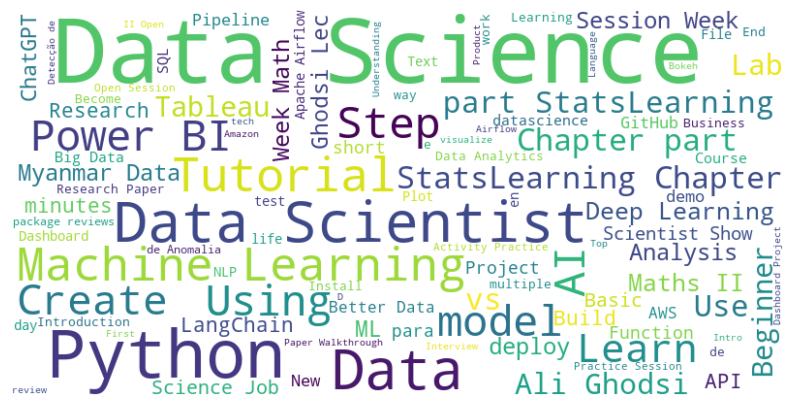

In [68]:
#word clooud for top-performing videos
top_titles = ' '.join(top_videos['title'].values)

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(top_titles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

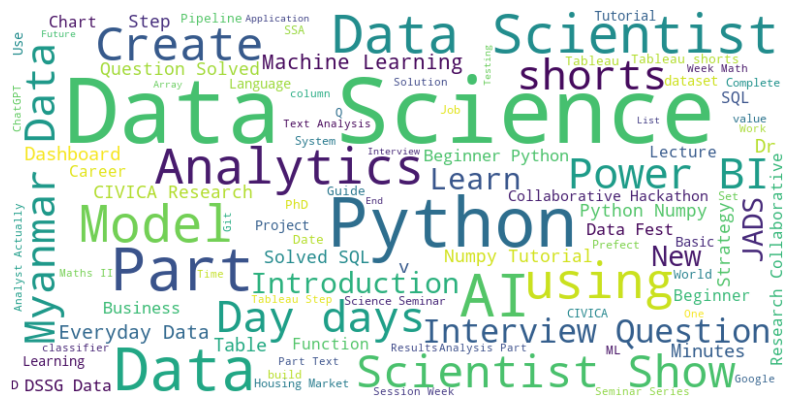

In [67]:
#word clooud for bottom-performing videos
bottom_titles = ' '.join(bottom_videos['title'].values)

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(bottom_titles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

By comparing the two word cloud, we could see that although they share many common general concepts related to data science, the dstinctive titles of top-performing videos are technical terms such as "deep learning", "AWS", "Apache Airflow", "LangChian", whereas for bottom-performing videos, the distinctive titles are "introduction", "interview question", "SQL". 

This comparison leads to a reasonable hypothesis: youtube videos that focus on teaching current data practioners more technical skills are more popular than those focus on introduction to data science

# 7. Use LangChain and ChatGPT to analyze titles for validating hypothesis

### 7.1 Set up API Call

In [306]:
import openai
import requests

In [308]:
from langchain.chat_models import ChatOpenAI
chat = ChatOpenAI(model_name ="gpt-3.5-turbo", temperature=0.0)

### 7.2 Initialize prompt template that will be combined with video title and sent to ChatGPT

In [309]:
# This is human message that defines specific task
task_template = """
You will be given a title of a youtube video covering data science related topics. 
Based soley on the title, please classify the video into below 5 categories.
----------------------------------------------------------------------------------------------
1. Upskill: This video is for people to learn advanced or job-specific data science skills, such as advanced machine learning, deep learning, data engineering skills.
2. Beginner: This video is for people to learn basic data science skills, including basic SQL, basic Python, baisc Power BI and basic Tableau.
3. Introduction: This video is for people to learn about what is data science or what data scientists do
4. Interviewprep: This video is for people to prepare for interviews
5. Unknown: If the video title is not informative for you to make a judgement, classify it as Unknown
----------------------------------------------------------------------------------------------
Now, please return the category of below video. 
Title: {video_title}
You answer must be one of the 5 categories: Upskill, Beginner, Introduction, Interviewprep, Unknown.
"""

In [323]:
# To better judge the content of these videos, we also define system message to let GPT play a role of experienced data scientist

from langchain.schema import SystemMessage

system_message = """
You are an experienced data scientist. You know what skills people at different stage of learning data science should learn 
"""

In [312]:
# Formulate final prompt template
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

human_message_prompt = HumanMessagePromptTemplate.from_template(task_template)
system_message_prompt = SystemMessagePromptTemplate.from_template(system_message)

chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
chat_prompt

ChatPromptTemplate(input_variables=['video_title'], output_parser=None, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], output_parser=None, partial_variables={}, template='\nYou are an experienced data scientist. You know what skills people at different stage of learning data science should learn \n', template_format='f-string', validate_template=True), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['video_title'], output_parser=None, partial_variables={}, template='\nYou will be given a title of a youtube video covering data science related topics. \nBased soley on the title, please classify the video into below 5 categories.\n----------------------------------------------------------------------------------------------\n1. Upskill: This video is for people to learn advanced or job-specific data science skills, such as advanced machine learning, deep learning, data engineering skills.\n2. B

### 7.3 Call ChatGPT to classify popular and unpopular videos and analyze the results

#### Analyze popular videos

In [313]:
popular_video_category = {}

for index in top_videos.index:
    
    title = top_videos.loc[index]['title']
    description = top_videos.loc[index]['description']
    messages = chat_prompt.format_prompt(video_title = title, video_description = description).to_messages()
    
    try:
        response = chat(messages)
        popular_video_category[title] = response.content
    
    except requests.exceptions.RequestException: 
        time.sleep(200)
        response = chat(messages)
        popular_video_category[title] = response.content
    
    except openai.error.ServiceUnavailableError:
        time.sleep(200)
        response = chat(messages)
        popular_video_category[title] = response.content

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Mon, 10 Jul 2023 18:15:40 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '7e4ac38afba82d8a-YVR', 'alt-svc': 'h3=":443"; ma=86400'}.
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad

In [326]:
# Create a dictionary in order to count the frequency of each category of popular videos

popular_video_category_ct = {
    'Upskill_ct': 0,
    'Beginner_ct':0,
    'Introduction_ct':0,
    'Interviewprep_ct':0,
    'Unknown_ct':0  
}


for k,v in popular_video_category.items():
    if v == 'Upskill':
        popular_video_category_ct['Upskill_ct'] += 1
    elif v == 'Beginner':
        popular_video_category_ct['Beginner_ct'] += 1
    elif v == 'Introduction':
        popular_video_category_ct['Introduction_ct'] += 1
    elif v == 'Interviewprep':
        popular_video_category_ct['Interviewprep_ct'] += 1
    else:
        popular_video_category_ct['Unknown_ct'] += 1

#### Analyze unpopular videos

In [316]:
unpopular_video_category = {}


for index in bottom_videos.index:
    
    title = bottom_videos.loc[index]['title']
    description = bottom_videos.loc[index]['description']
    messages = chat_prompt.format_prompt(video_title = title, video_description = description).to_messages()
    
    try:
        response = chat(messages)
        unpopular_video_category[title] = response.content
    
    except requests.exceptions.RequestException: 
        time.sleep(200)
        response = chat(messages)
        unpopular_video_category[title] = response.content
    
    except openai.error.ServiceUnavailableError:
        time.sleep(200)
        response = chat(messages)
        unpopular_video_category[title] = response.content

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Mon, 10 Jul 2023 18:39:01 GMT', 'Content-Type': 'appli

In [325]:
# Create a dictionary in order to count the frequency of each category of unpopular videos
unpopular_video_category_ct = {
    'Upskill_ct': 0,
    'Beginner_ct':0,
    'Introduction_ct':0,
    'Interviewprep_ct':0,
    'Unknown_ct':0  
}

for k,v in unpopular_video_category.items():
    if v == 'Upskill':
        unpopular_video_category_ct['Upskill_ct'] += 1
    elif v == 'Beginner':
        unpopular_video_category_ct['Beginner_ct'] += 1
    elif v == 'Introduction':
        unpopular_video_category_ct['Introduction_ct'] += 1
    elif v == 'Interviewprep':
        unpopular_video_category_ct['Interviewprep_ct'] += 1
    else:
        unpopular_video_category_ct['Unknown_ct'] += 1

#### Compare

In [318]:
print(popular_video_category_ct)
print(unpopular_video_category_ct)

{'Upskill_ct': 316, 'Beginner_ct': 58, 'Introduction_ct': 72, 'Interviewprep_ct': 7, 'Unknown_ct': 281}
{'Upskill_ct': 236, 'Beginner_ct': 57, 'Introduction_ct': 47, 'Interviewprep_ct': 28, 'Unknown_ct': 355}


We can see clearly popular videos have higher percentage in upskilling, whereas unpopular videos have higher percentage in interview preparation. 

# 8. Conclusion and Recommendation

In this analysis, we discovered that number of views for data-science related videos could vary greatly. Although specific channels have more visibility than others, the difference in views could not be totally accounted by channel itself.

We then used wordcloud and chatgpt to analyze the titles of popular and unpopular videos, and found that popular videos have a larger share of data science upskilling content, whereas unpopular videos have a larger share of interview preparation content.

This finding is not surprising. With the concept of data science becoming well-known and large number of data scientists employed in various industries, videos focusing on introduction, basic technical skills or interview advice are not as helpful for the majority data science audience compared with upskilling tutorials. 

Therefore, for people who want to leverage their data science skills to create popular youtube videos, they'd more likely to succeed in creating tutorials that help lots of junior data practioners quickly progress in this ever-changing field. 